In [480]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from esn_module import esn

from tqdm import tqdm_notebook as tqdm

std_figsize = (9.,4.)

Recall random pairs of real values on a pair of signals with period T

In [2]:
T = 500
reps = 10

sigm_in = 1.

inp=np.tile((np.random.rand(T)-.5)*2.*3.**.5*sigm_in,reps)
out=np.tile((np.random.rand(T)-.5)*2.*3.**.5,reps)

In [3]:
ESN = esn(N=1000,data_dim_in=1,data_dim_out=1,cf_w_in=.1,cf=1.,reg_fact=0.001,spec_rad=0.9)

ESN.learn_w_out(inp,out)
outpr = ESN.predict_data(inp)

<IPython.core.display.Javascript object>


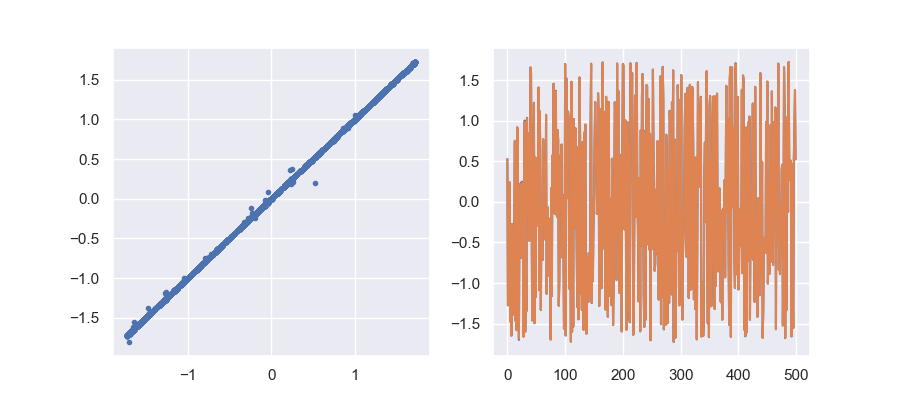

In [4]:
fig, ax = plt.subplots(1,2,figsize=std_figsize)
ax[0].plot(out,outpr,'.')
ax[1].plot(out[-T:])
ax[1].plot(outpr[-T:])
plt.show()

Recall Pairs of binary values and perform a XOR operation.

In [5]:
def gen_in_out_two_in_subs(T,tau):
    
    inp = np.ndarray((T,2))
    
    inp[:,0] = (np.random.rand(T) < .5)*1.
    inp[:,1] = 1.-inp[:,0]
    
    outp = np.ndarray((T))
    
    for k in range(T):
        
        if k - tau - 1 < 0:
            outp[k] = (np.random.rand() < .5)*1.
        else:
            outp[k] = (inp[k-tau,0] != inp[k-tau-1,0])*1.
    
    return inp, outp

In [6]:
def gen_in_out_two_in_parall(T,tau):
    
    inp = np.ndarray((T,2))
    
    inp = (np.random.rand(T,2) < .5)*1.
    
    outp = np.ndarray((T))
    
    for k in range(T):
        
        if k - tau < 0:
            outp[k] = (np.random.rand() < .5)*1.
        else:
            outp[k] = (inp[k-tau,0] != inp[k-tau,1])*1.
    
    return inp, outp

In [7]:
def gen_in_out_one_in_subs(T,tau):
    inp = np.ndarray((T))
    
    inp = (np.random.rand(T) < .5)*1.
        
    outp = np.ndarray((T))
    
    for k in range(T):
        
        if k - tau - 1 < 0:
            outp[k] = (np.random.rand() < .5)*1.
        else:
            outp[k] = (inp[k-tau] != inp[k-tau-1])*1.
    
    return inp, outp

Two binary input channels, each time slice encodes 0 and 1 in a "one active" way, the output performs XOR operations on subsequent pairs of inputs.

<IPython.core.display.Javascript object>


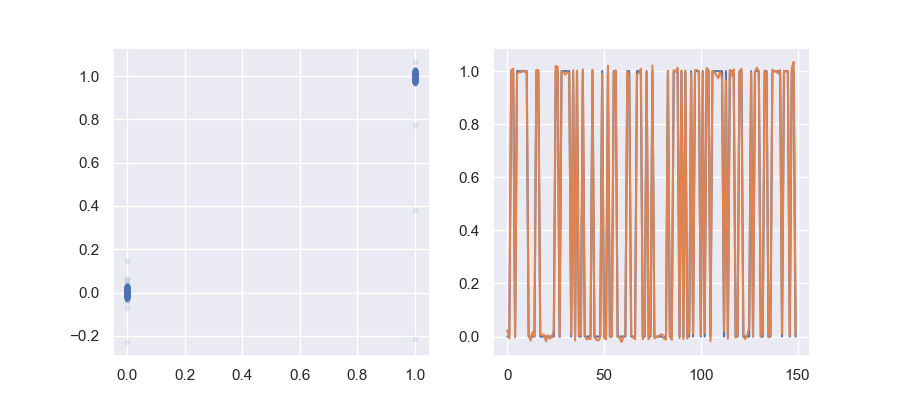

In [8]:
T = 5000

sigm_in = 1.
tau = 2

inp_xor, out_xor = gen_in_out_two_in_subs(T,tau)

### Define "Zero" with a minus one in the second channel
#inp_xor[:,1] *= -1.

ESN = esn(N=1000,data_dim_in=2,data_dim_out=1,cf_w_in=.1,cf=.1,reg_fact=0.001,spec_rad=.9,alpha=1.)

ESN.learn_w_out(inp_xor,out_xor,t_prerun=200)

inp_xor_test, out_xor_test = gen_in_out_two_in_subs(T,tau)
#inp_xor_test[:,1] *= -1.

out_xor_test_pr,y_rec = ESN.predict_data(inp_xor_test,return_reservoir_rec=True)
#out_xor_test_pr,y_rec = ESN.predict_data(inp_xor,return_reservoir_rec=True)

fig1, ax1 = plt.subplots(1,2,figsize=std_figsize)
#'''
ax1[0].plot(out_xor_test,out_xor_test_pr,'.',alpha=0.1)
ax1[1].plot(out_xor_test[-150:])
ax1[1].plot(out_xor_test_pr[-150:])
#'''
'''
ax1[0].plot(out_xor,out_xor_test_pr,'.')
ax1[1].plot(out_xor[-150:])
ax1[1].plot(out_xor_test_pr[-150:])
'''
plt.show()

Same thing, but binary zero is encoded with a minus one in the second channel.

<IPython.core.display.Javascript object>


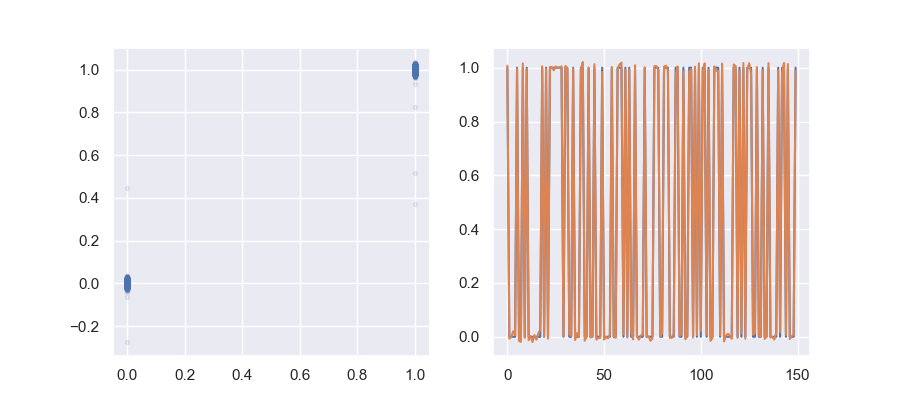

In [9]:
T = 5000

sigm_in = 1.
tau = 2

inp_xor, out_xor = gen_in_out_two_in_subs(T,tau)
### Define "Zero" with a minus one in the second channel
inp_xor[:,1] *= -1.

inp_xor_test, out_xor_test = gen_in_out_two_in_subs(T,tau)
inp_xor_test[:,1] *= -1.

ESN = esn(N=1000,data_dim_in=2,data_dim_out=1,cf_w_in=.1,cf=.1,reg_fact=0.001,spec_rad=.9,alpha=1.)

ESN.learn_w_out(inp_xor,out_xor,t_prerun=200)

out_xor_test_pr,y_rec = ESN.predict_data(inp_xor_test,return_reservoir_rec=True)

fig2, ax2 = plt.subplots(1,2,figsize=std_figsize)
#'''
ax2[0].plot(out_xor_test,out_xor_test_pr,'.',alpha=0.1)
ax2[1].plot(out_xor_test[-150:])
ax2[1].plot(out_xor_test_pr[-150:])
#'''
'''
ax1[0].plot(out_xor,out_xor_test_pr,'.')
ax1[1].plot(out_xor[-150:])
ax1[1].plot(out_xor_test_pr[-150:])
'''
plt.show()

One input channel, XOR operation is performed on subsequent elements with delay t-tau and t-tau-1. This is encoded with via 1 and -1, which makes the input symmetric. We discovered that a perfectly symmetric reservoir (zero biases) in combination with symmetric input will cause the learning to fail. However, adding small random biases to the each node in the reservoir suffices in solving this issue.

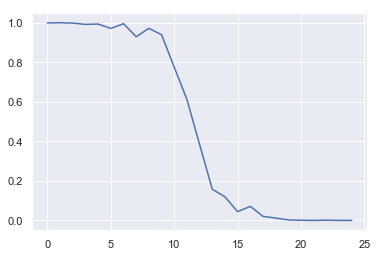

In [500]:
T = 2000

sigm_in = 1.

tau_max = 25

MC = np.ndarray((tau_max))

for k, tau in enumerate(tqdm(range(tau_max))):

    inp_xor, out_xor = gen_in_out_one_in_subs(T,tau)
    inp_xor_test, out_xor_test = gen_in_out_one_in_subs(T,tau)

    inp_xor = (inp_xor -.5)*2.*sigm_in
    inp_xor_test = (inp_xor_test -.5)*2.*sigm_in

    ESN = esn(N=1000,
              data_dim_in=1,
              data_dim_out=1,
              cf_w_in=.1,
              cf=1.,
              reg_fact=0.001,
              spec_rad=.85,
              alpha=1.,
              bias = np.random.normal(0.,0.2,(1000)))

    ESN.learn_w_out(inp_xor,out_xor,t_prerun=200,show_progress=False)

    out_xor_test_pr,y_rec = ESN.predict_data(inp_xor_test,return_reservoir_rec=True,show_progress=False)

    MC[k] = np.corrcoef(out_xor_test,out_xor_test_pr)[0,1]**2.

'''
fig3, ax3 = plt.subplots(1,2,figsize=std_figsize)

ax3[0].plot(out_xor_test,out_xor_test_pr,'.',alpha=0.1)
ax3[1].plot(out_xor_test[-150:])
ax3[1].plot(out_xor_test_pr[-150:])
'''

#'''
fig3, ax3 = plt.subplots()

ax3.plot(MC)
#'''



'''
ax1[0].plot(out_xor,out_xor_test_pr,'.')
ax1[1].plot(out_xor[-150:])
ax1[1].plot(out_xor_test_pr[-150:])
'''
plt.show()

In [502]:
def test_XOR_delay(N=1000,
                   T=1000,
                   tau_max=25,
                   sigm_in = 1.,
                    cf_w_in=.1,
                   cf=1.,
                   reg_fact=0.001,
                    spec_rad=.85,
                    alpha=1.,
                    bias = np.random.normal(0.,0.2,(1000))):
    MC = np.ndarray((tau_max))

    for k, tau in enumerate(tqdm(range(tau_max))):

        inp_xor, out_xor = gen_in_out_one_in_subs(T,tau)
        inp_xor_test, out_xor_test = gen_in_out_one_in_subs(T,tau)

        inp_xor = (inp_xor -.5)*2.*sigm_in
        inp_xor_test = (inp_xor_test -.5)*2.*sigm_in

        ESN = esn(N=1000,
                  data_dim_in=1,
                  data_dim_out=1,
                  cf_w_in=.1,
                  cf=1.,
                  reg_fact=0.001,
                  spec_rad=.85,
                  alpha=1.,
                  bias = np.random.normal(0.,0.2,(1000)))

        ESN.learn_w_out(inp_xor,out_xor,t_prerun=200,show_progress=False)

        out_xor_test_pr,y_rec = ESN.predict_data(inp_xor_test,return_reservoir_rec=True,show_progress=False)

        MC[k] = np.corrcoef(out_xor_test,out_xor_test_pr)[0,1]**2.
    return MC.sum(), MC

In [513]:
from simulation import driven_net

N = 1000
cf = 0.1

Net = driven_net(N_net = N,
                 cf_net = cf,
                 std_conn=1./(N*cf)**.5,
                 std_in = 0.5,
                 mu_act_target=(np.random.rand(N)-.5)*2.*0.1,
                std_act_target=0.25,
                eps_bias=0.0002,
                eps_gain=0.001,
                eps_trail_av_error=0.001,
                eps_trail_av_act=0.0001,
                n_t=50000,
                t_ext_off=50000)
Net.run_sim()
gain = Net.gain_rec[-1000:,:].mean()
bias = Net.bias_rec[-1000:,:].mean(axis=0)



100%|██████████| 50000/50000 [00:11<00:00, 4385.88it/s]


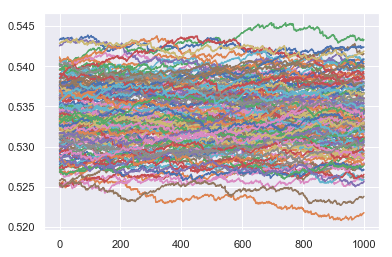

In [519]:
plt.plot(Net.gain_rec[-1000:,:150])
plt.show()

In [410]:
l_pca_y,v_pca_y = np.linalg.eig(y_cov)

sort = np.flip(np.argsort(l_pca_y))
l_pca_y = l_pca_y[sort]
v_pca_y = v_pca_y[:,sort]

<IPython.core.display.Javascript object>


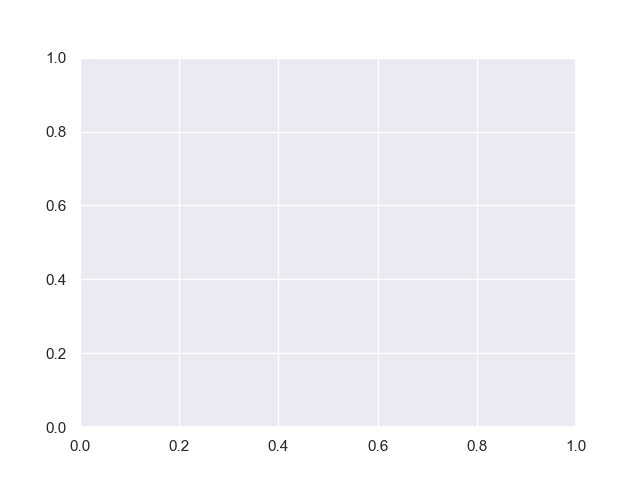

ValueError: shapes (1000,1000) and (2000,) not aligned: 1000 (dim 1) != 2000 (dim 0)

In [444]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig5 = plt.figure()
ax5 = fig5.add_subplot(111)

k0 = 1

#n_sample_k0 = 20
#n_sample_k1 = 20

#range_k0 = np.linspace(-5.,10.,n_sample_k0)
#range_k1 = np.linspace(-5.,13.,n_sample_k1)

#proj_w_out = np.ndarray((n_sample_k0,n_sample_k1))
'''
for k in range(n_sample_k0):
    for l in range(n_sample_k1):
        y = (range_k0[k]*v_pca_y[:,k0] + range_k1[l]*v_pca_y[:,k0+1])
        for n in range(tau-k0):
            y = np.tanh(ESN.W @ y)
        
        proj_w_out[l,k] = ESN.w_out[0,1:] @ y + ESN.w_out[0,0]

pcm = ax5.pcolormesh(range_k0,range_k1,proj_w_out)
'''
nscatt = 1000

ax5.scatter((y_rec[-nscatt:,1:] @ v_pca_y[:,k0]),(y_rec[-nscatt:,1:] @ v_pca_y[:,k0+1]),c=out_xor_test_pr[-nscatt:])
plt.colorbar(pcm)
plt.show()

<IPython.core.display.Javascript object>


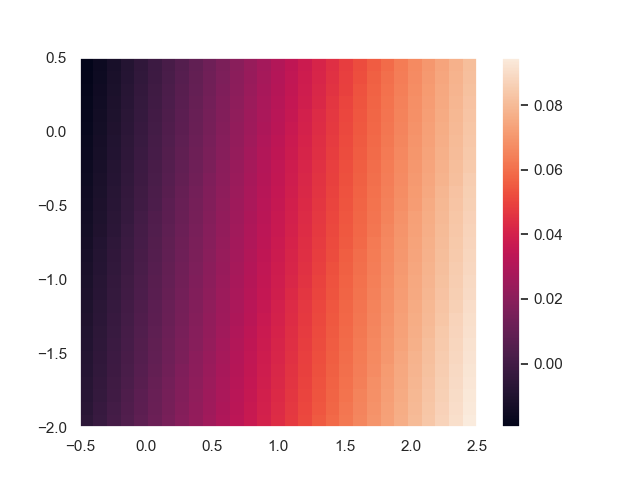

In [422]:
n_sample_k0 = 30
n_sample_k1 = 30

range_k0 = np.linspace(-.5,2.5,n_sample_k0)
range_k1 = np.linspace(-2.,.5,n_sample_k1)

proj_w_out = np.ndarray((n_sample_k0,n_sample_k1))

for k in range(n_sample_k0):
    for l in range(n_sample_k1):
        proj_w_out[l,k] = ESN.w_out[0,1:] @ np.tanh(ESN.W @ (range_k0[k]*v_pca_y[:,k0] + range_k1[l]*v_pca_y[:,k0+1]))

fig5_1,ax5_1 = plt.subplots()

pcm = ax5_1.pcolormesh(range_k0,range_k1,proj_w_out)
plt.colorbar(pcm)
plt.show()

<IPython.core.display.Javascript object>


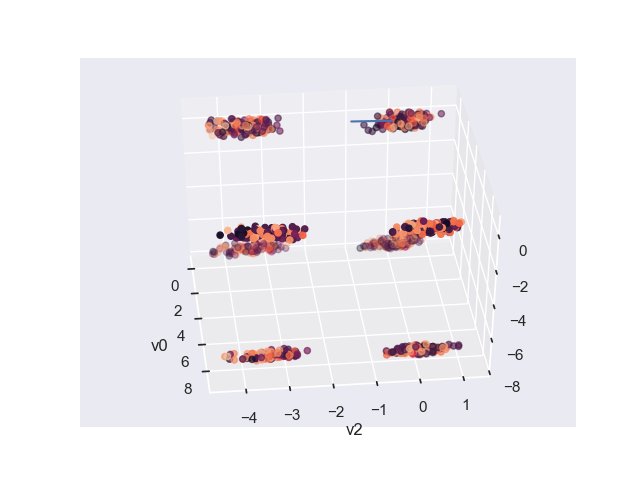

In [307]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

sortproj_wout = np.flip(np.argsort(np.abs((v_pca_y[:,:].T @ ESN.w_out[0,1:])*l_pca_y)))
#sortproj_wout = np.flip(np.argsort(np.abs((v_pca_y[:,:].T @ ESN.w_out[0,1:]))))


nscatt = 1000

ax6.scatter((y_rec[-nscatt:,1:] @ v_pca_y[:,sortproj_wout[0]]),(y_rec[-nscatt:,1:] @ v_pca_y[:,sortproj_wout[1]]),(y_rec[-nscatt:,1:] @ v_pca_y[:,sortproj_wout[2]]),c=out_xor_test_pr[-nscatt:])

w_proj = np.ndarray((3))
w_proj[0] = v_pca_y[:,sortproj_wout[0]] @ ESN.w_out[0,1:]
w_proj[1] = v_pca_y[:,sortproj_wout[1]] @ ESN.w_out[0,1:]
w_proj[2] = v_pca_y[:,sortproj_wout[2]] @ ESN.w_out[0,1:]

w_proj /= np.linalg.norm(w_proj)

ax6.plot([0.,w_proj[0]],[0.,w_proj[1]],[0.,w_proj[2]])

ax6.set_xlabel("v0")
ax6.set_ylabel("v1")
ax6.set_ylabel("v2")
#ax6.plot((v_pca_y[:,:].T @ ESN.w_out[0,1:])*l_pca_y,'.')
plt.show()

<IPython.core.display.Javascript object>


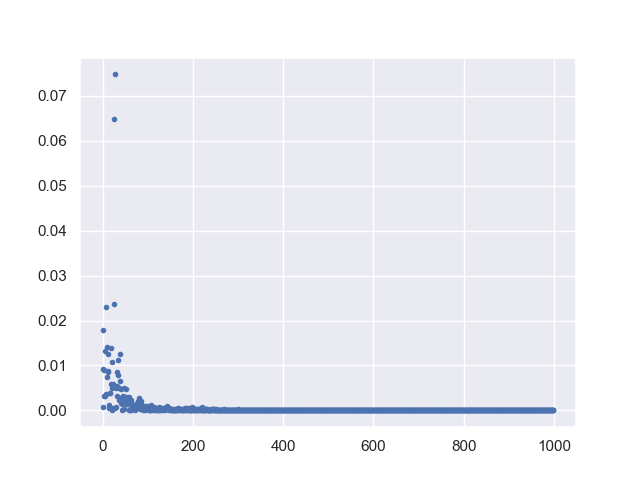

In [229]:
fig7,ax7 = plt.subplots()

plt.plot(np.abs((v_pca_y[:,:].T @ ESN.w_out[0,1:])*l_pca_y),'.')
plt.show()

Single input channel, XOR on subsequent values, which are encoded by 1 and -1.

<IPython.core.display.Javascript object>


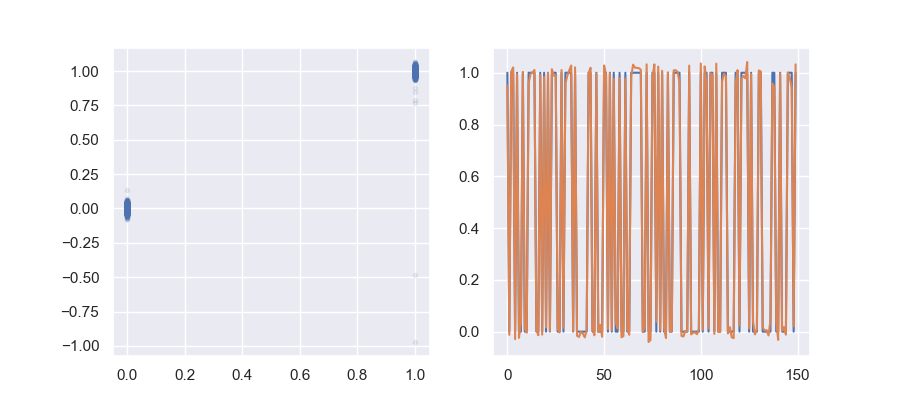

In [129]:
T = 5000

sigm_in = 1.
tau = 2

inp_xor, out_xor = gen_in_out_one_in_subs(T,tau)
inp_xor -= .5
inp_xor *= 2.

inp_xor_test, out_xor_test = gen_in_out_one_in_subs(T,tau)
inp_xor_test -= .5
inp_xor_test *= 2.

ESN = esn(N=1000,data_dim_in=1,data_dim_out=1,cf_w_in=.1,cf=.1,reg_fact=0.001,spec_rad=.9,alpha=1.,bias=np.random.normal(0.,0.05,(1000)))

ESN.learn_w_out(inp_xor,out_xor,t_prerun=200)

out_xor_test_pr,y_rec = ESN.predict_data(inp_xor_test,return_reservoir_rec=True)

fig3, ax3 = plt.subplots(1,2,figsize=std_figsize)
#'''
ax3[0].plot(out_xor_test,out_xor_test_pr,'.',alpha=0.1)
ax3[1].plot(out_xor_test[-150:])
ax3[1].plot(out_xor_test_pr[-150:])
#'''
'''
ax1[0].plot(out_xor,out_xor_test_pr,'.')
ax1[1].plot(out_xor[-150:])
ax1[1].plot(out_xor_test_pr[-150:])
'''
plt.show()

In [86]:
T = 5000

sigm_in = 1.
tau = 0

inp_xor, out_xor = gen_in_out_one_in_subs(T,tau)
#inp_xor -= .5
#inp_xor *= 2.

inp_xor_test, out_xor_test = gen_in_out_one_in_subs(T,tau)
#inp_xor_test -= .5
#inp_xor_test *= 2.

ESN = esn(N=2,data_dim_in=1,data_dim_out=1,cf_w_in=1.,cf=1.,reg_fact=0.001,spec_rad=.9,alpha=1.,bias=0.)

In [80]:
a = .9/2.**.5

w_in = 0.5

ESN.W = np.array([[0.,a],
                  [-a,0.]])

ESN.w_in = np.array([[w_in],[0.]])

<IPython.core.display.Javascript object>


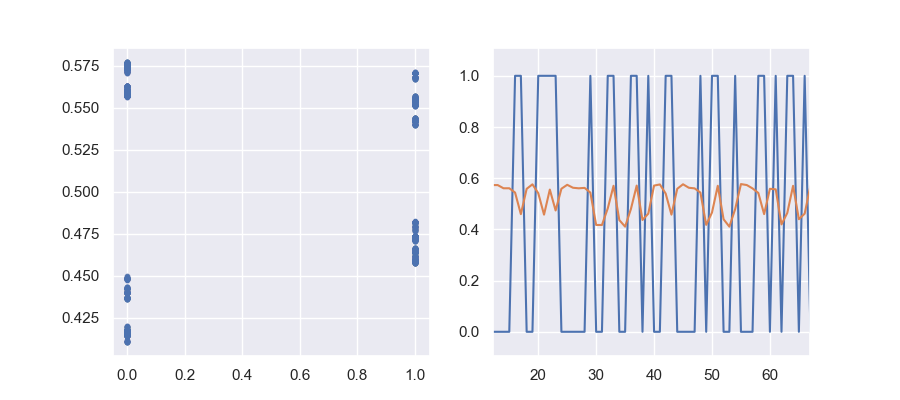

In [87]:
ESN.learn_w_out(inp_xor,out_xor,t_prerun=200)

out_xor_test_pr,y_rec = ESN.predict_data(inp_xor_test,return_reservoir_rec=True)



In [ ]:
fig2, ax2 = plt.subplots()

ax2.plot(y_rec[:,1:][:,(ESN.w_in[:,0]==0)][:100,:10])
ax2.plot(inp_xor_test[:100])
plt.show()

In [ ]:
fig3,ax3 = plt.subplots(2,1,figsize=std_figsize)
ax3[0].pcolormesh(y_rec[:500,:])
ax3[1].plot(ESN.w_out[:,1:].T)
plt.show()

In [ ]:
fig3_1,ax3_1 = plt.subplots()

ax3_1.bar(np.arange(2), [np.abs(ESN.w_out[0,1:][(ESN.w_in[:,0]==0)]).mean(),np.abs(ESN.w_out[0,1:][(ESN.w_in[:,0]!=0)]).mean()], 0.3,yerr=[np.abs(ESN.w_out[0,1:][(ESN.w_in[:,0]==0)]).std(),np.abs(ESN.w_out[0,1:][(ESN.w_in[:,0]!=0)]).std()])

plt.show()

In [ ]:
n_sweep = 20

shift = np.linspace(.4,.5,n_sweep)

r = np.ndarray((n_sweep))

for k in tqdm(range(n_sweep)):
    
    T = 5000

    sigm_in = 1.
    tau = 2

    inp_xor=(((np.random.rand(T,2)-.5)>0.)*1.-shift[k])*2.*sigm_in
    out_xor=(inp_xor[:-tau,0]!=inp_xor[:-tau,1])*1.
    inp_xor=inp_xor[tau:,:]
    
    ESN = esn(N=1000,data_dim_in=2,data_dim_out=1,cf_w_in=.1,cf=.1,reg_fact=0.001,spec_rad=.9,alpha=1.)

    ESN.learn_w_out(inp_xor,out_xor,t_prerun=200,show_progress=False)

    inp_xor_test=(((np.random.rand(T,2)-.5)>0.)*1.-shift[k])*2*sigm_in
    out_xor_test=(inp_xor_test[:-tau,0]!=inp_xor_test[:-tau,1])*1.

    inp_xor_test=inp_xor_test[tau:,:]

    out_xor_test_pr,y_rec = ESN.predict_data(inp_xor_test,return_reservoir_rec=True,show_progress=False)
    
    r[k] = np.corrcoef(out_xor_test,out_xor_test_pr)[0,1]


In [ ]:
fig4,ax4 = plt.subplots()

ax4.plot(shift,r)

plt.show()

In [470]:
N = 10

A = np.random.normal(0.,0.9/N**.5,(N,N))
A[range(N),range(N)] = 0.

w = np.random.normal(0.,1.,(N))

n_t = 20000

u = np.random.rand(n_t)-.5

y = np.ndarray((n_t,N))

y[0,:] = 0.

for t in tqdm(range(1,n_t)):
    
    y[t,:] = A @ y[t-1,:] + u[t]*w

In [471]:
C = np.cov(y.T)

In [472]:
S = np.outer(w,w)

C_theo = np.array(S)

A_pow = np.array(A)

for k in tqdm(range(2000)):
    
    C_theo += A_pow @ S @ A_pow.T
    
    A_pow = A @ A_pow

C_theo *= (u**2.).mean()

<IPython.core.display.Javascript object>


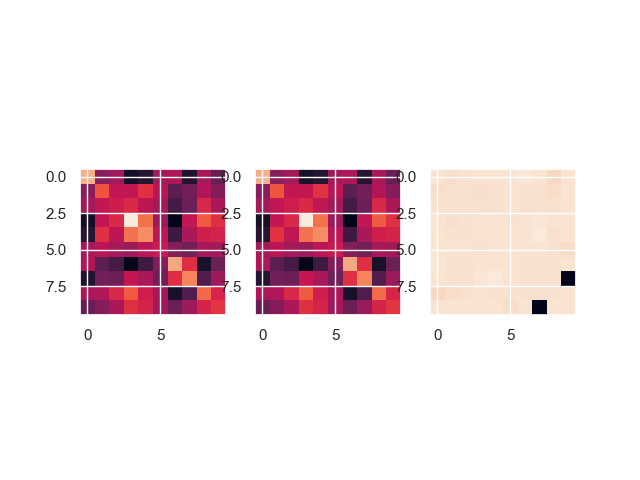

In [474]:
figC,axC = plt.subplots(1,3)

axC[0].imshow(C)
axC[1].imshow(C_theo)
axC[2].imshow(C/C_theo)

plt.show()

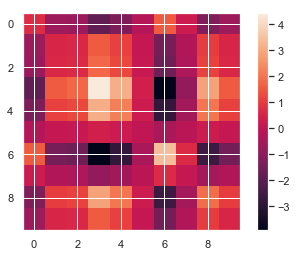

array([-5.33377651e-16, -2.52373767e-16, -2.52373767e-16, -3.52837757e-17,
       -3.52837757e-17,  0.00000000e+00,  1.39874508e-17,  8.66691058e-17,
        1.74853362e-16,  1.47474217e+01])

In [498]:
k = 0

plt.imshow(np.linalg.matrix_power(A,k) @ S @ np.linalg.matrix_power(A,k).T)
plt.colorbar()
plt.show()

l = np.linalg.eigvals(np.linalg.matrix_power(A,k) @ S @ np.linalg.matrix_power(A,k).T)

np.sort(l.real)